In [205]:
import json
import os
import string
import re
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer
from preprocessing.MILP_Algorithm import select_LP_optimal_subsequence
import numpy as np
from sklearn import tree
from tqdm import tqdm
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools, operator


# Read the data

In [57]:
eval_pred = open("data/milp_SQuAD2.0_eval_pred.txt", "r")
test_pred = open("data/milp_SQuAD2.0_test_pred.txt", "r")
y2_eval = open("data/milp_SQuAD2.0_y2_eval.txt", "r")
y3_eval = open("data/milp_SQuAD2.0_y3_eval.txt", "r")
y2_test = open("data/milp_SQuAD2.0_y2_test.txt", "r")
y3_test = open("data/milp_SQuAD2.0_y3_test.txt", "r")

eval_pred  = json.loads(eval_pred.read())
test_pred  = json.loads(test_pred.read())
y2_eval  = json.loads(y2_eval.read())
y3_eval  = json.loads(y3_eval.read())
y2_test  = json.loads(y2_test.read())
y3_test  = json.loads(y3_test.read())

eval_pred = [[0 if math.isnan(y) else y for y in x] for x in eval_pred]
test_pred = [[0 if math.isnan(y) else y for y in x] for x in test_pred]


In [58]:
# set max length value
max_len = 300
# Create the tokenizer
save_path = os.path.expanduser("~") + "/.bert_base_uncased/"
if not os.path.exists(save_path):
    slow_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    os.makedirs(save_path)
    slow_tokenizer.save_pretrained(save_path)
tokenizer = BertWordPieceTokenizer(save_path + "vocab.txt", lowercase=True)


# MILP
## Using a Decision tree to find the answerability threshold

In [77]:
# eval_pred_start_end = []
# with tqdm(total=len(eval_pred)) as pbar:
#     for idx, probabilities in enumerate(eval_pred):
#         s_pred,e_pred,_ = select_LP_optimal_subsequence(probabilities)
#         eval_pred_start_end.append([s_pred, e_pred])  
#         pbar.update(1)



100%|██████████| 7031/7031 [59:58<00:00,  1.95it/s]  


In [118]:
X = []
y = []
with tqdm(total=len(eval_pred_start_end)) as pbar:
    for idx, s_pred_e_pred in enumerate(eval_pred_start_end):
        s_pred = s_pred_e_pred[0]
        e_pred = s_pred_e_pred[1]
        prediction = list(range(s_pred, e_pred+1))          
        expected_p = np.sum(eval_pred[idx][s_pred:e_pred+1]) / len(prediction)
        X.append([expected_p])
        if np.sum(y2_eval[idx]) == 0:
            y.append(0)
        else:
            y.append(1)            
        pbar.update(1)

        


100%|██████████| 7031/7031 [00:00<00:00, 41081.10it/s]


[Text(167.4, 163.07999999999998, 'X[0] <= 0.385\ngini = 0.472\nsamples = 7031\nvalue = [2689, 4342]'),
 Text(83.7, 54.360000000000014, 'gini = 0.355\nsamples = 2346\nvalue = [1805, 541]'),
 Text(251.10000000000002, 54.360000000000014, 'gini = 0.306\nsamples = 4685\nvalue = [884, 3801]')]

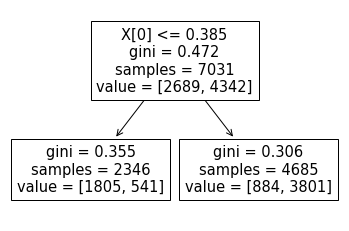

In [159]:
clf_MILP = tree.DecisionTreeClassifier(max_depth=1)
clf_MILP.fit(X, y)
tree.plot_tree(clf_MILP) 


In [80]:
# test_pred_start_end = []
# with tqdm(total=len(test_pred)) as pbar:
#     for idx, probabilities in enumerate(test_pred):
#         s_pred,e_pred,_ = select_LP_optimal_subsequence(probabilities)
#         test_pred_start_end.append([s_pred, e_pred])  
#         pbar.update(1)



100%|██████████| 11792/11792 [1:42:52<00:00,  1.91it/s] 


## Compute performance

In [122]:
def normalize_text(text):
    text = text.lower()

    # Remove punctuations
    exclude = set(string.punctuation)
    text = "".join(ch for ch in text if ch not in exclude)

    # Remove articles
    regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
    text = re.sub(regex, " ", text)

    # Remove extra white space
    text = " ".join(text.split())
    return text



In [194]:
count_MILP = []
p_MILP = []
r_MILP = []
f1_MILP = []

TN_MILP = 0
FN_MILP = 0
TP_MILP = 0
FP_MILP = 0
TAG_MILP = []

with tqdm(total=len(test_pred_start_end)) as pbar:
    for idx, s_pred_e_pred in enumerate(test_pred_start_end):
        s_pred = s_pred_e_pred[0]
        e_pred = s_pred_e_pred[1]
        prediction = list(range(s_pred, e_pred+1))        
        expected_p = np.sum(test_pred[idx][s_pred:e_pred+1]) / len(prediction)        
        answerability = clf_MILP.predict([[expected_p]])[0]
        if  answerability == 0 and np.sum(y2_test[idx]) == 0: # Correct predicion of unanswerability
            TN_MILP += 1
            TAG_MILP.append('TN')
            p_MILP.append(1)
            r_MILP.append(1)
            f1_MILP.append(1)
            count_MILP.append(1)
            pbar.set_description(f"[EM={np.mean(count_MILP):.3f}|F1={np.mean(f1_MILP):.3f}±{(1.96 * np.std(f1_MILP))/np.sqrt(len(f1_MILP)):.3f}|P={np.mean(p_MILP):.3f}±{(1.96 * np.std(p_MILP))/np.sqrt(len(p_MILP)):.3f}|R={np.mean(r_MILP):.3f}±{(1.96 * np.std(r_MILP))/np.sqrt(len(r_MILP)):.3f}]")    
            pbar.update(1)
            continue
        elif answerability == 1 and np.sum(y2_test[idx]) == 0 or answerability == 0 and np.sum(y2_test[idx]) > 0:
             # Incorrect predicion of answerability
            if answerability == 1:
                FP_MILP += 1
                TAG_MILP.append('FP')
            else:
                FN_MILP += 1
                TAG_MILP.append('FN')
            p_MILP.append(0)
            r_MILP.append(0)
            f1_MILP.append(0)
            count_MILP.append(0)            
            pbar.set_description(f"[EM={np.mean(count_MILP):.3f}|F1={np.mean(f1_MILP):.3f}±{(1.96 * np.std(f1_MILP))/np.sqrt(len(f1_MILP)):.3f}|P={np.mean(p_MILP):.3f}±{(1.96 * np.std(p_MILP))/np.sqrt(len(p_MILP)):.3f}|R={np.mean(r_MILP):.3f}±{(1.96 * np.std(r_MILP))/np.sqrt(len(r_MILP)):.3f}]")    
            pbar.update(1)
            continue
        else:   # Correct predicion of answerability      
            TP_MILP += 1
            TAG_MILP.append('TP')
            ans = list(y3_test[idx])

            normalized_pred_ans = normalize_text(tokenizer.decode(prediction))
            normalized_true_ans = normalize_text(tokenizer.decode(ans))

            if normalized_pred_ans == normalized_true_ans:
                count_MILP.append(1)
            else:
                count_MILP.append(0)
            prediction = set(normalized_pred_ans.split(' '))
            true = set(normalized_true_ans.split(' '))
            inter = set(prediction & true)
            p_ = len(inter) / len(prediction)
            r_ = len(inter) / len(true)  
            f1_ = 0
            if (p_+r_) !=0:
                f1_ = 2*p_*r_ / (p_+r_)
            p_MILP.append(p_)
            r_MILP.append(r_)
            f1_MILP.append(f1_)
            pbar.set_description(f"[EM={np.mean(count_MILP):.3f}|F1={np.mean(f1_MILP):.3f}±{(1.96 * np.std(f1_MILP))/np.sqrt(len(f1_MILP)):.3f}|P={np.mean(p_MILP):.3f}±{(1.96 * np.std(p_MILP))/np.sqrt(len(p_MILP)):.3f}|R={np.mean(r_MILP):.3f}±{(1.96 * np.std(r_MILP))/np.sqrt(len(r_MILP)):.3f}]")    
            pbar.update(1)
        
print(f"[EM={np.mean(count_MILP):.3f}|F1={np.mean(f1_MILP):.3f}±{(1.96 * np.std(f1_MILP))/np.sqrt(len(f1_MILP)):.3f}|P={np.mean(p_MILP):.3f}±{(1.96 * np.std(p_MILP))/np.sqrt(len(p_MILP)):.3f}|R={np.mean(r_MILP):.3f}±{(1.96 * np.std(r_MILP))/np.sqrt(len(r_MILP)):.3f}]")        
print(f"[TP={TP_MILP/len(TAG_MILP):.3f}|TN={TN_MILP/len(TAG_MILP):.3f}|TP={FP_MILP/len(TAG_MILP):.3f}|TP={FN_MILP/len(TAG_MILP):.3f}]")




[EM=0.542|F1=0.655±0.008|P=0.646±0.008|R=0.696±0.008]: 100%|██████████| 11792/11792 [01:05<00:00, 178.80it/s]


[EM=0.542|F1=0.655±0.008|P=0.646±0.008|R=0.696±0.008]
[TP=0.432|TN=0.318|TP=0.186|TP=0.064]


# Baseline 1
## Using a Decision tree to find the answerability threshold

In [173]:
eval_pred_start_baseline1 = open("data/Baseline1_SQuAD2.0_eval_pred_start.txt", "r")
eval_pred_end_baseline1 = open("data/Baseline1_SQuAD2.0_eval_pred_end.txt", "r")
test_pred_start_baseline1 = open("data/Baseline1_SQuAD2.0_test_pred_start.txt", "r")
test_pred_end_baseline1 = open("data/Baseline1_SQuAD2.0_test_pred_end.txt", "r")
y2_eval_baseline1 = open("data/Baseline1_SQuAD2.0_y2_eval.txt", "r")
y3_eval_baseline1 = open("data/Baseline1_SQuAD2.0_y3_eval.txt", "r")
y2_test_baseline1 = open("data/Baseline1_SQuAD2.0_y2_test.txt", "r")
y3_test_baseline1 = open("data/Baseline1_SQuAD2.0_y3_test.txt", "r")

eval_pred_start_baseline1  = json.loads(eval_pred_start_baseline1.read())
eval_pred_end_baseline1  = json.loads(eval_pred_end_baseline1.read())
test_pred_start_baseline1  = json.loads(test_pred_start_baseline1.read())
test_pred_end_baseline1  = json.loads(test_pred_end_baseline1.read())
y2_eval_baseline1  = json.loads(y2_eval_baseline1.read())
y3_eval_baseline1  = json.loads(y3_eval_baseline1.read())
y2_test_baseline1  = json.loads(y2_test_baseline1.read())
y3_test_baseline1  = json.loads(y3_test_baseline1.read())

eval_pred_start_baseline1 = [[0 if math.isnan(y) else y for y in x] for x in eval_pred_start_baseline1]
eval_pred_end_baseline1 = [[0 if math.isnan(y) else y for y in x] for x in eval_pred_end_baseline1]
test_pred_start_baseline1 = [[0 if math.isnan(y) else y for y in x] for x in test_pred_start_baseline1]
test_pred_end_baseline1 = [[0 if math.isnan(y) else y for y in x] for x in test_pred_end_baseline1]


100%|██████████| 7031/7031 [00:00<00:00, 18257.66it/s]


[Text(167.4, 163.07999999999998, 'X[0] <= 0.507\ngini = 0.472\nsamples = 7031\nvalue = [2689, 4342]'),
 Text(83.7, 54.360000000000014, 'gini = 0.297\nsamples = 4799\nvalue = [869, 3930]'),
 Text(251.10000000000002, 54.360000000000014, 'gini = 0.301\nsamples = 2232\nvalue = [1820, 412]')]

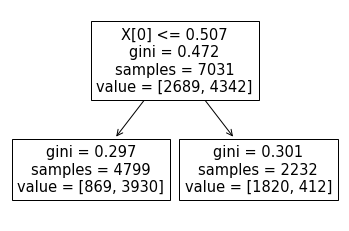

In [182]:
X_baseline1 = []
y_baseline1 = []
with tqdm(total=len(eval_pred_start_baseline1)) as pbar:
    for idx, (start, end) in enumerate(zip(eval_pred_start_baseline1, eval_pred_end_baseline1)):
        s_pred = np.max(start[1:]) + np.max(end[1:])
        s_null = start[0] + end[0]
        X_baseline1.append([s_null-s_pred])
        if np.sum(y2_eval_baseline1[idx]) == 0:
            y_baseline1.append(0)
        else:
            y_baseline1.append(1)  
        pbar.update(1)       

clf_Baseline1 = tree.DecisionTreeClassifier(max_depth=1)
clf_Baseline1.fit(X_baseline1, y_baseline1)
tree.plot_tree(clf_Baseline1)         


In [193]:
count_Baseline1 = []
p_Baseline1 = []
r_Baseline1 = []
f1_Baseline1 = []

TN_Baseline1 = 0
FN_Baseline1 = 0
TP_Baseline1 = 0
FP_Baseline1 = 0
TAG_Baseline1 = []

with tqdm(total=len(test_pred_start_baseline1)) as pbar:
    for idx, (start, end) in enumerate(zip(test_pred_start_baseline1, test_pred_end_baseline1)):  
        s_pred = np.max(start[1:]) + np.max(end[1:])
        s_null = start[0] + end[0]
        answerability = clf_Baseline1.predict([[s_null-s_pred]])[0]        
        if  answerability == 0 and np.sum(y2_test_baseline1[idx]) == 0: # Correct predicion of unanswerability
            TN_Baseline1 += 1
            TAG_Baseline1.append('TN')
            p_Baseline1.append(1)
            r_Baseline1.append(1)
            f1_Baseline1.append(1)
            count_Baseline1.append(1)
            pbar.set_description(f"[EM={np.mean(count_Baseline1):.3f}|F1={np.mean(f1_Baseline1):.3f}±{(1.96 * np.std(f1_Baseline1))/np.sqrt(len(f1_Baseline1)):.3f}|P={np.mean(p_Baseline1):.3f}±{(1.96 * np.std(p_Baseline1))/np.sqrt(len(p_Baseline1)):.3f}|R={np.mean(r_Baseline1):.3f}±{(1.96 * np.std(r_Baseline1))/np.sqrt(len(r_Baseline1)):.3f}]")
            pbar.update(1)
            continue
        elif answerability == 1 and np.sum(y2_test_baseline1[idx]) == 0 or answerability == 0 and np.sum(y2_test_baseline1[idx]) > 0:
             # Incorrect predicion of answerability
            if answerability == 1:
                FP_Baseline1 += 1
                TAG_Baseline1.append('FP')
            else:
                FN_Baseline1 += 1
                TAG_Baseline1.append('FN')
            p_Baseline1.append(0)
            r_Baseline1.append(0)
            f1_Baseline1.append(0)
            count_Baseline1.append(0)            
            pbar.set_description(f"[EM={np.mean(count_Baseline1):.3f}|F1={np.mean(f1_Baseline1):.3f}±{(1.96 * np.std(f1_Baseline1))/np.sqrt(len(f1_Baseline1)):.3f}|P={np.mean(p_Baseline1):.3f}±{(1.96 * np.std(p_Baseline1))/np.sqrt(len(p_Baseline1)):.3f}|R={np.mean(r_Baseline1):.3f}±{(1.96 * np.std(r_Baseline1))/np.sqrt(len(r_Baseline1)):.3f}]")
            pbar.update(1)
            continue
        else:   # Correct predicion of answerability   
            TP_Baseline1 += 1
            TAG_Baseline1.append('TP')
            s_pred = np.argmax(start)
            e_pred = np.argmax(end)
            prediction = set(range(s_pred, e_pred+1))  
            ans = set(y3_test_baseline1[idx])  
            inter = list(prediction & ans)
            if len(prediction) == 0:
                p_Baseline1.append(0)
                r_Baseline1.append(0)
                f1_Baseline1.append(0)
                count_Baseline1.append(0)
                pbar.update(1)
                continue
            p_ = len(inter) / len(prediction)
            r_ = len(inter) / len(ans)
            f1_ = 0
            if (p_+r_) !=0:
                f1_ = 2*p_*r_ / (p_+r_)
            if f1_ == 1:
                count_Baseline1.append(1)
            else:
                count_Baseline1.append(0)
            p_Baseline1.append(p_)
            r_Baseline1.append(r_)
            f1_Baseline1.append(f1_)
            pbar.set_description(f"[EM={np.mean(count_Baseline1):.3f}|F1={np.mean(f1_Baseline1):.3f}±{(1.96 * np.std(f1_Baseline1))/np.sqrt(len(f1_Baseline1)):.3f}|P={np.mean(p_Baseline1):.3f}±{(1.96 * np.std(p_Baseline1))/np.sqrt(len(p_Baseline1)):.3f}|R={np.mean(r_Baseline1):.3f}±{(1.96 * np.std(r_Baseline1))/np.sqrt(len(r_Baseline1)):.3f}]")
            pbar.update(1)
    
print(f"[EM={np.mean(count_Baseline1):.3f}|F1={np.mean(f1_Baseline1):.3f}±{(1.96 * np.std(f1_Baseline1))/np.sqrt(len(f1_Baseline1)):.3f}|P={np.mean(p_Baseline1):.3f}±{(1.96 * np.std(p_Baseline1))/np.sqrt(len(p_Baseline1)):.3f}|R={np.mean(r_Baseline1):.3f}±{(1.96 * np.std(r_Baseline1))/np.sqrt(len(r_Baseline1)):.3f}]")
print(f"[TP={TP_Baseline1/len(TAG_Baseline1):.3f}|TN={TN_Baseline1/len(TAG_Baseline1):.3f}|TP={FP_Baseline1/len(TAG_Baseline1):.3f}|TP={FN_Baseline1/len(TAG_Baseline1):.3f}]")


[EM=0.601|F1=0.682±0.008|P=0.696±0.008|R=0.700±0.008]: 100%|██████████| 11792/11792 [01:09<00:00, 169.68it/s]

[EM=0.601|F1=0.682±0.008|P=0.696±0.008|R=0.700±0.008]
[TP=0.439|TN=0.347|TP=0.157|TP=0.057]


# Baseline 2

In [225]:
def baseline2(A):
    B = np.where(np.array(A) > 0.5, 1, 0)
    if np.sum(B) == 0:
        return -1, -1
    else:
        r = max((list(y) for (x,y) in itertools.groupby((enumerate(B)),operator.itemgetter(1)) if x == 1), key=len)
        return r[0][0], r[-1][0]
    
    

In [226]:
count_Baseline2 = []
p_Baseline2 = []
r_Baseline2 = []
f1_Baseline2 = []

TN_Baseline2 = 0
FN_Baseline2 = 0
TP_Baseline2 = 0
FP_Baseline2 = 0
TAG_Baseline2 = []

with tqdm(total=len(test_pred_start_end)) as pbar:
    for idx, s_pred_e_pred in enumerate(test_pred_start_end):
        s_pred, e_pred = baseline2(probabilities)
        if s_pred == -1 or e_pred == 1:
            answerability = 0       
        
        if  answerability == 0 and np.sum(y2_test[idx]) == 0: # Correct predicion of unanswerability
            TN_Baseline2 += 1
            TAG_Baseline2.append('TN')
            p_Baseline2.append(1)
            r_Baseline2.append(1)
            f1_Baseline2.append(1)
            count_Baseline2.append(1)
            pbar.set_description(f"[EM={np.mean(count_Baseline2):.3f}|F1={np.mean(f1_Baseline2):.3f}±{(1.96 * np.std(f1_Baseline2))/np.sqrt(len(f1_Baseline2)):.3f}|P={np.mean(p_Baseline2):.3f}±{(1.96 * np.std(p_Baseline2))/np.sqrt(len(p_Baseline2)):.3f}|R={np.mean(r_Baseline2):.3f}±{(1.96 * np.std(r_Baseline2))/np.sqrt(len(r_Baseline2)):.3f}]")    
            pbar.update(1)
            continue
        elif answerability == 1 and np.sum(y2_test[idx]) == 0 or answerability == 0 and np.sum(y2_test[idx]) > 0:
             # Incorrect predicion of answerability
            if answerability == 1:
                FP_Baseline2 += 1
                TAG_Baseline2.append('FP')
            else:
                FN_Baseline2 += 1
                TAG_Baseline2.append('FN')
            p_Baseline2.append(0)
            r_Baseline2.append(0)
            f1_Baseline2.append(0)
            count_Baseline2.append(0)            
            pbar.set_description(f"[EM={np.mean(count_Baseline2):.3f}|F1={np.mean(f1_Baseline2):.3f}±{(1.96 * np.std(f1_Baseline2))/np.sqrt(len(f1_Baseline2)):.3f}|P={np.mean(p_Baseline2):.3f}±{(1.96 * np.std(p_Baseline2))/np.sqrt(len(p_Baseline2)):.3f}|R={np.mean(r_Baseline2):.3f}±{(1.96 * np.std(r_Baseline2))/np.sqrt(len(r_Baseline2)):.3f}]")    
            pbar.update(1)
            continue
        else:   # Correct predicion of answerability
            TP_Baseline2 += 1
            TAG_Baseline2.append('TP')        
            prediction = list(range(s_pred, e_pred + 1))
            ans = list(y3_test[idx])
            normalized_pred_ans = normalize_text(tokenizer.decode(prediction))
            normalized_true_ans = normalize_text(tokenizer.decode(ans))
            if normalized_pred_ans == normalized_true_ans:                
                count_Baseline2.append(1)
            else:
                count_Baseline2.append(0)
            prediction = set(normalized_pred_ans.split(' '))
            true = set(normalized_true_ans.split(' '))
            inter = set(prediction & true)
            p_ = len(inter) / len(prediction)
            r_ = len(inter) / len(true)
            f1_ = 0
            if (p_ + r_) != 0:
                f1_ = 2 * p_ * r_ / (p_ + r_)
            p_Baseline2.append(p_)
            r_Baseline2.append(r_)
            f1_Baseline2.append(f1_)
            pbar.set_description(f"[EM={np.mean(count_Baseline2):.3f}|F1={np.mean(f1_Baseline2):.3f}±{(1.96 * np.std(f1_Baseline2))/np.sqrt(len(f1_Baseline2)):.3f}|P={np.mean(p_Baseline2):.3f}±{(1.96 * np.std(p_Baseline2))/np.sqrt(len(p_Baseline2)):.3f}|R={np.mean(r_Baseline2):.3f}±{(1.96 * np.std(r_Baseline2))/np.sqrt(len(r_Baseline2)):.3f}]")
            pbar.update(1)

print(f"[EM={np.mean(count_Baseline2):.3f}|F1={np.mean(f1_Baseline2):.3f}±{(1.96 * np.std(f1_Baseline2))/np.sqrt(len(f1_Baseline2)):.3f}|P={np.mean(p_Baseline2):.3f}±{(1.96 * np.std(p_Baseline2))/np.sqrt(len(p_Baseline2)):.3f}|R={np.mean(r_Baseline2):.3f}±{(1.96 * np.std(r_Baseline2))/np.sqrt(len(r_Baseline2)):.3f}]")
print(f"[TP={TP_Baseline2/len(TAG_Baseline2):.3f}|TN={TN_Baseline2/len(TAG_Baseline2):.3f}|TP={FP_Baseline2/len(TAG_Baseline2):.3f}|TP={FN_Baseline2/len(TAG_Baseline2):.3f}]")


[EM=0.504|F1=0.504±0.009|P=0.504±0.009|R=0.504±0.009]: 100%|██████████| 11792/11792 [00:49<00:00, 237.19it/s]


[EM=0.504|F1=0.504±0.009|P=0.504±0.009|R=0.504±0.009]
[TP=0.000|TN=0.504|TP=0.000|TP=0.496]


# Plots

In [227]:
data = pd.DataFrame(columns=['algo','accuracy','f1', 'precision',  'recall'])
data_list = list(zip(['MILP']*len(count_MILP), count_MILP, f1_MILP, p_MILP, r_MILP))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','f1', 'precision',  'recall']),ignore_index=True)

data_list = list(zip(['Baseline 1']*len(count_Baseline2), count_Baseline1, f1_Baseline1, p_Baseline1, r_Baseline1))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','f1', 'precision',  'recall']),ignore_index=True)

data_list = list(zip(['Baseline 2']*len(count_Baseline2), count_Baseline2, f1_Baseline2, p_Baseline2, r_Baseline2))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','f1', 'precision',  'recall']),ignore_index=True)




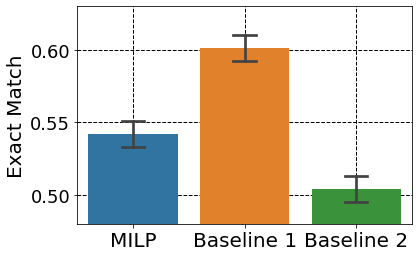

In [228]:
# statistic, pvalue = stats.ttest_ind(acc2, acc_baseline2)
ax = sns.barplot(x="algo", y="accuracy", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("Exact Match")
# plt.title("Box plot of #candidates per cycle and system")
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
plt.ylim(0.48, 0.63)
plt.savefig('plots/em_SQuAD2.0.eps', bbox_inches = 'tight')
plt.show()


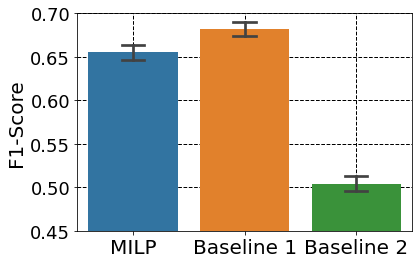

In [229]:
# statistic, pvalue = stats.ttest_ind(f1_2, f1_baseline2)
ax = sns.barplot(x="algo", y="f1", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("F1-Score")
# plt.title("Box plot of #candidates per cycle and system")
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
plt.ylim(0.45, 0.7)
plt.savefig('plots/f1_score_SQuAD2.0.eps', bbox_inches = 'tight')
plt.show()


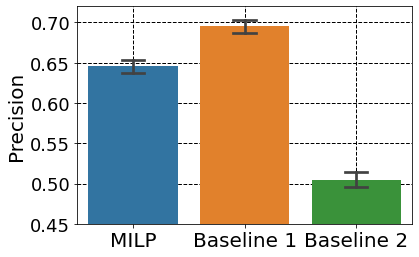

In [230]:
# statistic, pvalue = stats.ttest_ind(p2, p_baseline2)
ax = sns.barplot(x="algo", y="precision", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)
plt.xlabel("")
plt.ylabel("Precision")
# plt.title("Box plot of #candidates per cycle and system")
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
plt.ylim(0.45, 0.72)
plt.savefig('plots/precision_SQuAD2.0.eps', bbox_inches = 'tight')
plt.show()


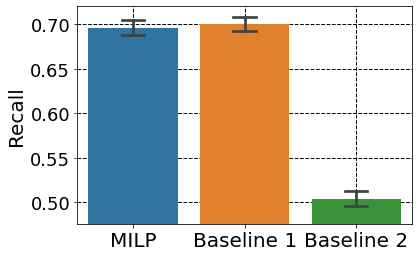

In [231]:
# statistic, pvalue = stats.ttest_ind(r2, r_baseline2)
ax = sns.barplot(x="algo", y="recall", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} < 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)
plt.xlabel("")
plt.ylabel("Recall")
# plt.title("Box plot of #candidates per cycle and system")
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
plt.ylim(0.476, 0.72)
plt.savefig('plots/recall_SQuAD2.0.eps', bbox_inches = 'tight')
plt.show()
